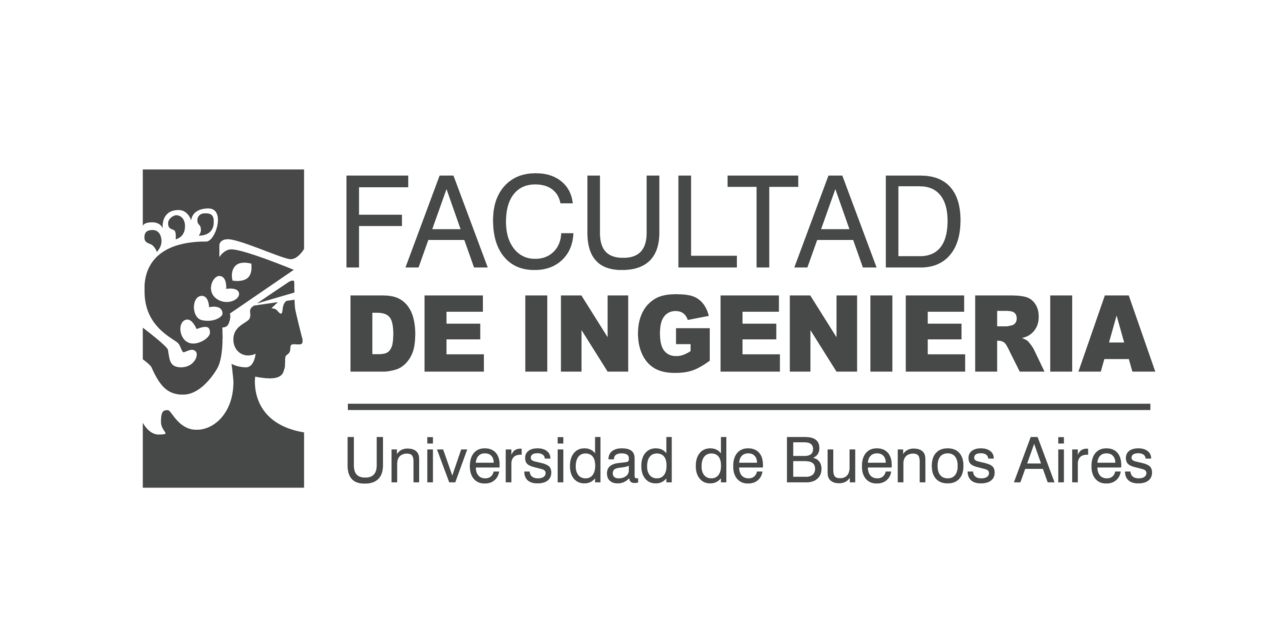

**Desafío 4:** <br />
LSTM Traductor

**Profesores:** <br />
Dr. Rodrigo Cardenas Szigety - rodrigo.cardenas.sz@gmail.com <br />
Dr. Nicolás Vattuone - nicolas.vattuone@gmail.com <br />

**Alumno:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-nlp - Ver desafios/desafio_4/Desafio_4.ipynb<br />


### Consigna y Sugerencias

El objectivo de este trabajo es realizar un traductor Ingles-Español utilizando una arquitectura seq2seq Endocder-Decoder basada en LSTM. Se utilizará como dataset el conjunto de traducciones de texto en diferentes idiomas de Anki.

[Dataset](https://www.manythings.org/anki/)

Se utilizara pytorch para implementar la arquitectura Encoder-Decoder para continuar con el stack de los trabajos entregados anteriormente.

<img src="img/architecture.png" alt="Traducción Inglés-Español con LSTM Encoder-Decoder" style="width:30%;">

### Requerimientos y utilidades

In [1]:
%pip install torch
%pip install torchinfo
%pip install gdown
%pip install plotly
%pip install wordcloud
%pip install nltk
%pip install matplotlib pandas seaborn numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.
  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
import json
import gdown
import torch
import numpy as np
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Carga y preprocesamiento de dataset

#### 1- Descarga dataset

In [4]:
def download_dataset(folder: str, url: str, zip_file: str) -> None:
    """
    Descarga y descomprime un dataset desde una URL.
    Args:
        folder (str): Nombre de la carpeta donde se guardará el dataset.
        url (str): URL del archivo zip del dataset.
        zip_file (str): Nombre del archivo zip a descargar.
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    zip_path = os.path.join(folder, zip_file)
    if not os.path.exists(zip_path):
        gdown.download(url, zip_path, quiet=False)
        os.system(f'unzip -q {zip_path} -d {folder}')
    else:
        print(f"El dataset '{zip_file}' ya se encuentra descargado en '{folder}'")

# Descargar el dataset de español-inglés:
download_dataset('data', 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', 'spa-eng.zip')


Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /home/jgonzalez/dev/ceia-nlp/desafios/desafio_4/data/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:02<00:00, 1.11MB/s]


#### 2- Preprocesamiento

In [2]:
def load_sentence_pairs(folder: str, filename: str, seed: int = 40, max_num_sentences: int = 6000) -> Tuple[List[str], List[str], List[str]]:
    """
    Carga y preprocesa pares de oraciones desde un archivo de texto.
    
    Args:
        folder (str): Carpeta donde se encuentra el archivo.
        filename (str): Nombre del archivo de texto.
        max_num_sentences (int): Máximo número de pares de oraciones a cargar.
        
    Returns:
        Tuple[List[str], List[str], List[str]]: 
            input_sentences, output_sentences, output_sentences_inputs
    """
    text_file = os.path.join(folder, filename)
    with open(text_file, encoding="utf-8") as f:
        lines = f.read().split("\n")[:-1]

    np.random.seed([seed])
    np.random.shuffle(lines)

    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []
    count = 0

    for line in lines:
        if count >= max_num_sentences:
            break
        if '\t' not in line:
            continue
        input_sentence, output = line.rstrip().split('\t')
        output_sentence = output + ' '
        output_sentence_input = ' ' + output
        input_sentences.append(input_sentence) # la que se le da al encoder. Es la secuencia de entrada.
        output_sentences.append(output_sentence) # se le da un token <eos> al final. Es la secuencia objetivo o target. La que el decoder debe aprender a predecir.
        output_sentences_inputs.append(output_sentence_input) # se le da un token <sos> al inicio. Es la secuencia de entrada para el decoder (teacher forcing).
        count += 1

    print("Cantidad de rows disponibles:", len(lines))
    print("Cantidad de rows utilizadas:", len(input_sentences))
    print("Ejemplo:")
    print("input_sentence (EN):", input_sentences[0])
    print("output_sentence (ES):", output_sentences[0])
    print("output_sentence_input (ES):", output_sentences_inputs[0])
    return input_sentences, output_sentences, output_sentences_inputs

In [3]:
input_sentences, output_sentences, output_sentences_inputs = load_sentence_pairs('data/spa-eng', 'spa.txt', max_num_sentences=118964)

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964
Ejemplo:
input_sentence (EN): A deal is a deal.
output_sentence (ES): Un trato es un trato. 
output_sentence_input (ES):  Un trato es un trato.


Antes de pasar a la capa de embeddings, necesitamos un vocabulario. Es decir, un mapeo entre palabras unicas de las oraciones en ingles y español mapeadas a tokens numéricos que seran la entrada de la capa de embeddings de la seq2seq.

In [4]:
def tokenize(sentence: str, filters: str = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n') -> List[str]:
    """
    Tokeniza una oración eliminando símbolos definidos en `filters`.

    Args:
        sentence (str): Oración en texto.
        filters (str): Caracteres a eliminar antes de tokenizar.

    Returns:
        List[str]: Lista de tokens limpios.
    """
    sentence = sentence.lower().strip()
    for ch in filters:
        sentence = sentence.replace(ch, "")
    return sentence.split()


def build_tokenizer(
    sentences: List[str],
    max_vocab_size: int = 8000,
    language: str = "english"
) -> Tuple[Dict[str, int], List[List[str]]]:
    """
    Construye un vocabulario y tokeniza las oraciones en secuencias de enteros.

    Args:
        sentences (List[str]): Lista de oraciones.
        max_vocab_size (int): Tamaño máximo del vocabulario (incluye tokens especiales).
        language (str): Nombre de referencia para impresión.

    Returns:
        Tuple:
            - word2idx (Dict[str, int]): Diccionario token → índice.
            - tokenized_sentences (List[List[str]]): Lista de listas de tokens.
    """
    tokenized_sentences = [tokenize(s) for s in sentences]
    counter = Counter(token for sent in tokenized_sentences for token in sent)

    total_vocab = len(counter)
    print(f"Vocabulario total {language} (sin filtrar): {total_vocab} palabras únicas.")

    most_common = counter.most_common(max_vocab_size - 4)

    word2idx = {
        "<pad>": 0,
        "<sos>": 1,
        "<eos>": 2,
        "<unk>": 3
    }
    for i, (word, _) in enumerate(most_common, start=4):
        word2idx[word] = i

    print(f"Vocabulario usado {language} (top {max_vocab_size - 4} + 4 especiales): {len(word2idx)} palabras.")

    return word2idx, tokenized_sentences


def encode_sentences(
    tokenized_sentences: List[List[str]],
    word2idx: Dict[str, int],
    add_sos: bool = False,
    add_eos: bool = False
) -> List[List[int]]:
    """
    Convierte listas de tokens a listas de índices numéricos.

    Args:
        tokenized_sentences (List[List[str]]): Lista de tokens por oración.
        word2idx (Dict[str, int]): Vocabulario token → índice.
        add_sos (bool): Agregar <sos> al inicio.
        add_eos (bool): Agregar <eos> al final.

    Returns:
        List[List[int]]: Secuencias de índices.
    """
    sequences = []
    for tokens in tokenized_sentences:
        seq = []
        if add_sos:
            seq.append(word2idx["<sos>"])
        seq.extend([word2idx.get(t, word2idx["<unk>"]) for t in tokens])
        if add_eos:
            seq.append(word2idx["<eos>"])
        sequences.append(seq)
    return sequences


In [5]:
# Tamaño máximo del vocabulario
MAX_VOCAB_SIZE_ENGLISH = 13000  
MAX_VOCAB_SIZE_SPANISH = 20000  

# Tokenizer + vocabulario
input_word2idx, input_tokens = build_tokenizer(input_sentences, MAX_VOCAB_SIZE_ENGLISH, "english")
output_word2idx, output_tokens = build_tokenizer(output_sentences, MAX_VOCAB_SIZE_SPANISH, "spanish")

# Codificación separada
input_sequences = encode_sentences(input_tokens, input_word2idx)
output_sequences = encode_sentences(output_tokens, output_word2idx, add_eos=True)
output_input_sequences = encode_sentences(output_tokens, output_word2idx, add_sos=True)



Vocabulario total english (sin filtrar): 13812 palabras únicas.
Vocabulario usado english (top 12996 + 4 especiales): 13000 palabras.
Vocabulario total spanish (sin filtrar): 26448 palabras únicas.
Vocabulario usado spanish (top 19996 + 4 especiales): 20000 palabras.


In [6]:
print(f"Cantidad de palabras únicas en el vocabulario de entrada (inglés): {len(input_word2idx)}")
tmp = [print(f"{word}: {idx}") for word, idx in list(input_word2idx.items())[:10]]
print(f"Cantidad de palabras únicas en el vocabulario de salida (español): {len(output_word2idx)}")
tmp = [print(f"{word}: {idx}") for word, idx in list(output_word2idx.items())[:10]]

Cantidad de palabras únicas en el vocabulario de entrada (inglés): 13000
<pad>: 0
<sos>: 1
<eos>: 2
<unk>: 3
the: 4
i: 5
to: 6
you: 7
tom: 8
a: 9
Cantidad de palabras únicas en el vocabulario de salida (español): 20000
<pad>: 0
<sos>: 1
<eos>: 2
<unk>: 3
de: 4
que: 5
a: 6
no: 7
tom: 8
la: 9


Dado que no hay problemas de recursos, se utiliza todo el dataset y numeros de MAX_VOCAB_SIZE ceranos al total.

In [7]:
# Generamos mapeo inverso para poder decodificar los índices a palabras
input_idx2word = {idx: word for word, idx in input_word2idx.items()}
output_idx2word = {idx: word for word, idx in output_word2idx.items()}

In [8]:
i = 0

print("Oración original (EN):", input_sentences[i])
print("Traducción (ES):", output_sentences[i])
print("Traducción (ES, input para decoder):", output_sentences_inputs[i])
print()

# Tokens numéricos
print("Tokens EN (input):", input_sequences[i])
print("Tokens ES (output):", output_sequences[i])
print("Tokens ES (input para decoder):", output_input_sequences[i])
print()

# Decodificación a texto
decoded_input = " ".join([input_idx2word.get(idx, "<unk>") for idx in input_sequences[i]])
decoded_output = " ".join([output_idx2word.get(idx, "<unk>") for idx in output_sequences[i]])
decoded_output_input = " ".join([output_idx2word.get(idx, "<unk>") for idx in output_input_sequences[i]])

print("Decodificado EN:", decoded_input)
print("Decodificado ES:", decoded_output)
print("Decodificado ES (input para decoder):", decoded_output_input)

Oración original (EN): A deal is a deal.
Traducción (ES): Un trato es un trato. 
Traducción (ES, input para decoder):  Un trato es un trato.

Tokens EN (input): [9, 926, 10, 9, 926]
Tokens ES (output): [13, 2149, 12, 13, 2149, 2]
Tokens ES (input para decoder): [1, 13, 2149, 12, 13, 2149]

Decodificado EN: a deal is a deal
Decodificado ES: un trato es un trato <eos>
Decodificado ES (input para decoder): <sos> un trato es un trato


Para poder hacer batching, vemos los tamaños medios y maximos de las oraciones para poder elegir un buen valor para el entrenamiento.

In [9]:
def analyze_sequence_lengths(name: str, sequences: List[List[int]]) -> None:
    lengths = [len(seq) for seq in sequences]
    print(f"\nAnálisis de longitudes para: {name}")
    print(f"Total de secuencias: {len(sequences)}")
    print(f"Longitud máxima: {np.max(lengths)}")
    print(f"Longitud media: {np.mean(lengths):.2f}")
    print(f"Percentil 95: {np.percentile(lengths, 95):.0f}")
    print(f"Percentil 99: {np.percentile(lengths, 99):.0f}")
    print(f"Ejemplo de secuencia más larga: {sequences[np.argmax(lengths)]}")


In [10]:
analyze_sequence_lengths("input (EN)", input_sequences)
analyze_sequence_lengths("output_input (ES)", output_input_sequences)
analyze_sequence_lengths("output_target (ES)", output_sequences)



Análisis de longitudes para: input (EN)
Total de secuencias: 118964
Longitud máxima: 47
Longitud media: 6.31
Percentil 95: 11
Percentil 99: 14
Ejemplo de secuencia más larga: [67, 7, 34, 6, 726, 38, 9, 1038, 1294, 7, 145, 32, 1451, 6, 1978, 598, 4, 270, 1065, 182, 37, 182, 12, 4, 270, 170, 14, 4892, 2238, 1978, 4, 270, 4823, 182, 37, 182, 352, 48, 42, 202, 15, 3449, 37, 39, 4, 10683, 10684]

Análisis de longitudes para: output_input (ES)
Total de secuencias: 118964
Longitud máxima: 50
Longitud media: 7.08
Percentil 95: 12
Percentil 99: 16
Ejemplo de secuencia más larga: [1, 48, 123, 1796, 52, 13, 1893, 1451, 310, 119, 1590, 6, 4380, 906, 9, 431, 1382, 19, 31, 176, 69, 4, 9, 431, 485, 11, 5, 13, 2029, 4, 7803, 10665, 10, 165, 19081, 19, 31, 176, 69, 144, 5, 18, 3887, 609, 3995, 31, 11, 10, 58, 2119]

Análisis de longitudes para: output_target (ES)
Total de secuencias: 118964
Longitud máxima: 50
Longitud media: 7.08
Percentil 95: 12
Percentil 99: 16
Ejemplo de secuencia más larga: [48, 

P99 nos da 14 y 16 respectivamente para Ingles y Español.

In [11]:
def pad_sequences(
    sequences: List[List[int]],
    pad_idx: int,
    max_len: int
) -> List[List[int]]:
    """
    Aplica padding a una lista de secuencias hasta max_len.

    Args:
        sequences (List[List[int]]): Lista de secuencias de enteros.
        pad_idx (int): Índice del token <pad>.
        max_len (int): Longitud fija deseada.

    Returns:
        List[List[int]]: Secuencias padded.
    """
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            padded_seq = seq + [pad_idx] * (max_len - len(seq))
        else:
            padded_seq = seq[:max_len]  # truncamos si hace falta
        padded.append(padded_seq)
    return padded

In [12]:
MAX_LEN_EN = 16      # cubriría 99% del input
MAX_LEN_ES = 20      # un poco más para decoder input/output

PAD_IDX_EN = input_word2idx["<pad>"]
PAD_IDX_ES = output_word2idx["<pad>"]

input_padded = pad_sequences(input_sequences, PAD_IDX_EN, MAX_LEN_EN)
output_input_padded = pad_sequences(output_input_sequences, PAD_IDX_ES, MAX_LEN_ES)
output_target_padded = pad_sequences(output_sequences, PAD_IDX_ES, MAX_LEN_ES)

In [13]:
i = 0  # índice de ejemplo

print("Input EN original (sin padding):")
print(input_sequences[i])
print("Longitud:", len(input_sequences[i]))

print("\nInput EN padded:")
print(input_padded[i])
print("Longitud:", len(input_padded[i]))

print("\nOutput ES (input para decoder) original:")
print(output_input_sequences[i])
print("Longitud:", len(output_input_sequences[i]))

print("\nOutput ES padded:")
print(output_input_padded[i])
print("Longitud:", len(output_input_padded[i]))

print("\nOutput ES (target del decoder) padded:")
print(output_target_padded[i])
print("Longitud:", len(output_target_padded[i]))


Input EN original (sin padding):
[9, 926, 10, 9, 926]
Longitud: 5

Input EN padded:
[9, 926, 10, 9, 926, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Longitud: 16

Output ES (input para decoder) original:
[1, 13, 2149, 12, 13, 2149]
Longitud: 6

Output ES padded:
[1, 13, 2149, 12, 13, 2149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Longitud: 20

Output ES (target del decoder) padded:
[13, 2149, 12, 13, 2149, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Longitud: 20


In [14]:
# Dividir el dataset en entrenamiento y validación
# Usamos 15% para validación
train_input, val_input, \
train_output_input, val_output_input, \
train_output_target, val_output_target = train_test_split(
    input_padded,
    output_input_padded,
    output_target_padded,
    test_size=0.15,
    random_state=42
)


class TranslationDataset(Dataset):
    def __init__(self, src, tgt_in, tgt_out):
        self.src = src
        self.tgt_in = tgt_in
        self.tgt_out = tgt_out

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return {
            "encoder_input": torch.tensor(self.src[idx], dtype=torch.long),
            "decoder_input": torch.tensor(self.tgt_in[idx], dtype=torch.long),
            "decoder_target": torch.tensor(self.tgt_out[idx], dtype=torch.long)
        }



In [15]:
BATCH_SIZE = 128

train_dataset = TranslationDataset(train_input, train_output_input, train_output_target)
val_dataset = TranslationDataset(val_input, val_output_input, val_output_target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [16]:
print(f"Tamaño del conjunto de entrenamiento (train_loader): {len(train_loader.dataset)} muestras")
print(f"Número de batches en train_loader: {len(train_loader)}")

print(f"Tamaño del conjunto de validación (val_loader): {len(val_loader.dataset)} muestras")
print(f"Número de batches en val_loader: {len(val_loader)}")

Tamaño del conjunto de entrenamiento (train_loader): 101119 muestras
Número de batches en train_loader: 790
Tamaño del conjunto de validación (val_loader): 17845 muestras
Número de batches en val_loader: 140


### Embeddings

Se elije **glove.6B.100d.txt** por presentar un buen balance entre los disponibles.

Ejecutar: 
```bash
wget http://nlp.stanford.edu/data/glove.6B.zip --no-check-certificate
mv glove.6B.zip data && cd data/
unzip glove.6B.zip
```

| Archivo              | Vocab Size | Dimensión | Tamaño   |
|----------------------|--------|-----------|----------|
| glove.6B.50d.txt     | 400K   | 50        | ~70MB    |
| **glove.6B.100d.txt**   | **400K**   | **100**       | **~130MB**   |
| glove.6B.200d.txt    | 400K   | 200       | ~250MB   |
| glove.6B.300d.txt    | 400K   | 300       | ~370MB   |

- Corpus: Wikipedia + Gigaword (clean and general)
- Vocab: 400K
- Embedding dim: 100

In [17]:
def load_glove_embeddings(glove_path: str) -> dict:
    """
    Carga los embeddings GloVe desde un archivo .txt.

    Returns:
        Dict[str, np.ndarray]: Diccionario palabra → vector
    """
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

def build_embedding_matrix(word2idx: dict, glove_embeddings: dict, embedding_dim: int) -> np.ndarray:
    """
    Construye una matriz de embeddings alineada con word2idx.
    Solo cargamos los embeddings de palabras que están en word2idx.

    Args:
        word2idx (dict): Vocabulario del modelo.
        glove_embeddings (dict): Diccionario de embeddings GloVe.
        embedding_dim (int): Dimensión de los vectores GloVe usados.

    Returns:
        np.ndarray: Matriz de embeddings.
    """
    vocab_size = len(word2idx)
    matrix = np.random.normal(0, 1, (vocab_size, embedding_dim)).astype(np.float32)
    for word, idx in word2idx.items():
        if word in glove_embeddings:
            matrix[idx] = glove_embeddings[word]
    return matrix


In [18]:
glove_path = "data/glove.6B.100d.txt"
embedding_dim = 100

glove_embeddings = load_glove_embeddings(glove_path)
embedding_matrix = build_embedding_matrix(input_word2idx, glove_embeddings, embedding_dim)


In [24]:
# Debe ser 13000, ya que tenemos 12996 palabras + 4 tokens especiales
print(f"Tamaño de la matriz de embeddings: {embedding_matrix.shape}")

Tamaño de la matriz de embeddings: (13000, 100)


In [26]:
# Freeze de pesos ya que no queremos entrenarlos
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

### Implementación de Modelos

A continuación, utilizando los embeddings de Glove definidos en la sección anterior (pre entrenados para inglés), definiremos un bloque encoder utilizando LSTM, un decoder y una Seq2Seq que utilizara a ambos dos para implementar la arquitectura objetivo.

In [28]:
class Encoder(nn.Module):
    def __init__(self, embedding_weights: torch.Tensor, hidden_dim: int, dropout: float = 0.5, num_layers: int = 1):
        super().__init__()
        vocab_size, embedding_dim = embedding_weights.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # dropout en embeddings
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell


In [33]:
class Decoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, dropout: float = 0.2, num_layers: int = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)  # (B) a (B, 1)
        embedded = self.dropout(self.embedding(input))  # dropout en embeddings
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))  # (B, vocab_size)
        return prediction, hidden, cell


In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[:, 0]  # first token (<sos>)

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


In [35]:
embedding_dim = 100
hidden_dim = 256
decoder_vocab_size = len(output_word2idx)
dropout = 0.2

encoder = Encoder(embedding_matrix, hidden_dim, num_layers=2, dropout=dropout)
decoder = Decoder(
    vocab_size=decoder_vocab_size, 
    embedding_dim=embedding_dim, 
    hidden_dim=hidden_dim,
    dropout=dropout,
    num_layers=2)

model = Seq2Seq(encoder, decoder, device).to(device)


### Entrenamiento

In [38]:
def train(model, train_loader, val_loader, optimizer, pad_idx, device, max_epochs=50, patience=5, name="seq2seq_model"):
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        "name": name,
        "train_loss": [],
        "val_loss": [],
        "train_time_seconds": None
    }

    os.makedirs("data", exist_ok=True)
    best_model_path = f"data/{name}_best_model.pt"
    history_path = f"data/{name}_train_history.json"

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0

        for batch in train_loader:
            src = batch["encoder_input"].to(device)
            trg_input = batch["decoder_input"].to(device)
            trg_target = batch["decoder_target"].to(device)

            optimizer.zero_grad()
            output = model(src, trg_input)  # (B, T, vocab)
            output = output[:, 1:].reshape(-1, output.shape[-1])  # skip <sos>
            trg_target = trg_target[:, 1:].reshape(-1)

            loss = criterion(output, trg_target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Nuevo mejor modelo guardado en {best_model_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No mejora. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Guardar historial de pérdidas
    with open(history_path, "w") as f:
        json.dump(history, f, indent=2)
    print(f"Historial guardado en {history_path}")
    
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    for batch in loader:
        src = batch["encoder_input"].to(device)
        trg_input = batch["decoder_input"].to(device)
        trg_target = batch["decoder_target"].to(device)

        output = model(src, trg_input)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg_target = trg_target[:, 1:].reshape(-1)

        loss = criterion(output, trg_target)
        total_loss += loss.item()

    return total_loss / len(loader)

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pad_idx = output_word2idx["<pad>"]

train(model, train_loader, val_loader, optimizer, pad_idx, device, max_epochs=30, patience=2)


[Epoch 1] Train Loss: 6.0119 | Val Loss: 5.7342
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 2] Train Loss: 5.4084 | Val Loss: 5.1120
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 3] Train Loss: 4.8247 | Val Loss: 4.5995
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 4] Train Loss: 4.3411 | Val Loss: 4.2181
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 5] Train Loss: 3.9475 | Val Loss: 3.9283
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 6] Train Loss: 3.6302 | Val Loss: 3.7211
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 7] Train Loss: 3.3806 | Val Loss: 3.5645
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 8] Train Loss: 3.1726 | Val Loss: 3.4438
Nuevo mejor modelo guardado en data/seq2seq_model_best_model.pt
[Epoch 9] Train Loss: 2.9929 | Val Loss: 3.3595
Nuevo mejor modelo guardado en data/seq2seq_model_best_m

In [42]:
def plot_train_history(json_path: str):
    """
    Dibuja curvas de pérdida de entrenamiento y validación a partir de un archivo JSON.

    Args:
        json_path (str): Ruta al archivo .json generado por la función de entrenamiento.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        history = json.load(f)

    train_loss = history["train_loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - {history['name']}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


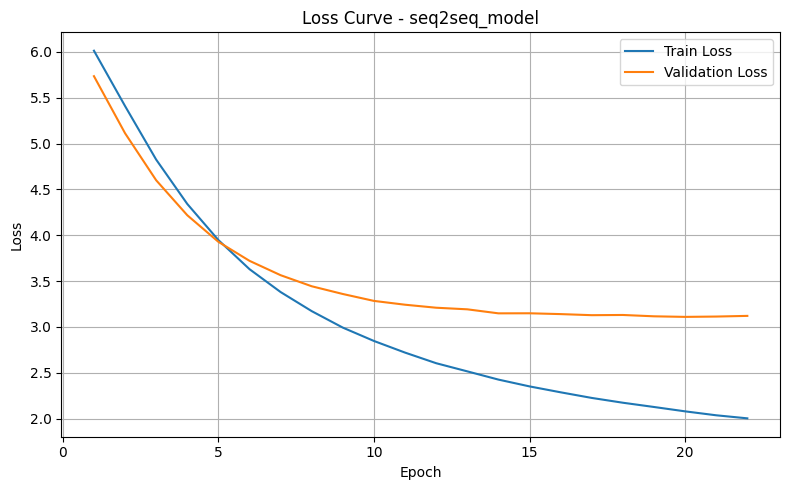

In [43]:
plot_train_history("data/seq2seq_model_train_history.json")

### Pruebas

In [44]:
model.load_state_dict(torch.load("data/seq2seq_model_best_model.pt"))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(13000, 100)
    (dropout): Dropout(p=0.2, inplace=False)
    (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (embedding): Embedding(20000, 100)
    (dropout): Dropout(p=0.2, inplace=False)
    (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc_out): Linear(in_features=256, out_features=20000, bias=True)
  )
)

In [45]:
def translate(model, src_tensor, input_idx2word, output_idx2word, max_len=20, device='cpu'):
    model.eval()
    with torch.no_grad():
        src_tensor = src_tensor.unsqueeze(0).to(device)  # (1, seq_len)
        hidden, cell = model.encoder(src_tensor)

        input_token = torch.tensor([output_word2idx["<sos>"]], device=device)

        outputs = []

        for _ in range(max_len):
            output, hidden, cell = model.decoder(input_token, hidden, cell)
            pred_token = output.argmax(1).item()
            if pred_token == output_word2idx["<eos>"]:
                break
            outputs.append(pred_token)
            input_token = torch.tensor([pred_token], device=device)

        decoded = [output_idx2word.get(idx, "<unk>") for idx in outputs]
        return " ".join(decoded)


In [46]:
for i in range(5):
    src_tensor = val_dataset[i]["encoder_input"]
    trg_tensor = val_dataset[i]["decoder_target"]

    src_tokens = [input_idx2word.get(idx.item(), "<unk>") for idx in src_tensor if idx != input_word2idx["<pad>"]]
    trg_tokens = [output_idx2word.get(idx.item(), "<unk>") for idx in trg_tensor if idx not in [output_word2idx["<pad>"], output_word2idx["<eos>"]]]

    src_sentence = " ".join(src_tokens)
    trg_sentence = " ".join(trg_tokens)

    pred_sentence = translate(model, src_tensor, input_idx2word, output_idx2word, device=device)

    print(f"\nInput      : {src_sentence}")
    print(f"Reference  : {trg_sentence}")
    print(f"Predicted  : {pred_sentence}")



Input      : this is a gorgeous town
Reference  : es una ciudad preciosa
Predicted  : es una ciudad

Input      : i need to know where to put this
Reference  : necesito saber dónde poner esto
Predicted  : saber dónde esto esto

Input      : i'm so happy to see you again
Reference  : estoy tan feliz de verte de nuevo
Predicted  : muy feliz de verte verte

Input      : what kind of medicine did you take
Reference  : qué clase de remedio <unk>
Predicted  : tipo de tu me

Input      : her manners are not those of a lady
Reference  : ella no se comporta como una dama
Predicted  : modales no son son de una


### Conclusiones